In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
matplotlib.rcParams.update({'font.size': 22})
rc('text', usetex=True)

In [3]:
from pyke.prf import PRFPhotometry

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
from pyke.prf import SimpleKeplerPRF

In [5]:
from pyke.targetpixelfile import KeplerTargetPixelFile

In [6]:
from pyke.utils import KeplerQualityFlags

In [7]:
tpf = KeplerTargetPixelFile('kplr010053146-2013011073258_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK)

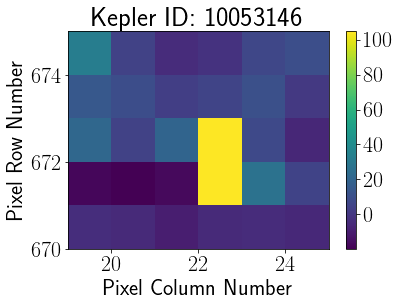

In [79]:
tpf.plot(frame=1)

In [10]:
lc = tpf.to_lightcurve()

In [59]:
aper_flux = lc.flux

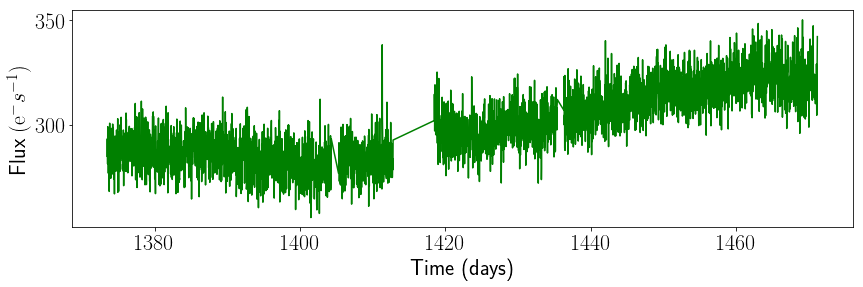

In [60]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, lc.flux, color='green')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

In [61]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [62]:
from oktopus.prior import UniformPrior

In [95]:
prior = UniformPrior(lb=[100, 21, 670, 10],
                     ub=[1e4, 24, 674, 300])

In [96]:
from pyke.prf import SceneModel

In [97]:
scene = SceneModel(prfs=[prf])

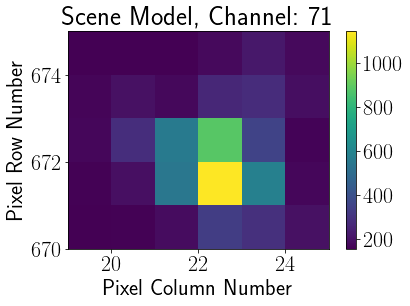

In [98]:
scene.plot(*prior.mean)

In [99]:
phot_poisson = PRFPhotometry(scene_model=scene, prior=prior)

In [100]:
results = phot_poisson.fit(tpf_flux=(tpf.flux + tpf.flux_bkg), options={'ftol':1e-9})

  0%|          | 0/4118 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 4118/4118 [03:16<00:00, 20.92it/s]


In [101]:
flux = results[:, 0]
xcenter = results[:, 1]
ycenter = results[:, 2]
bkg = results[:, 3]

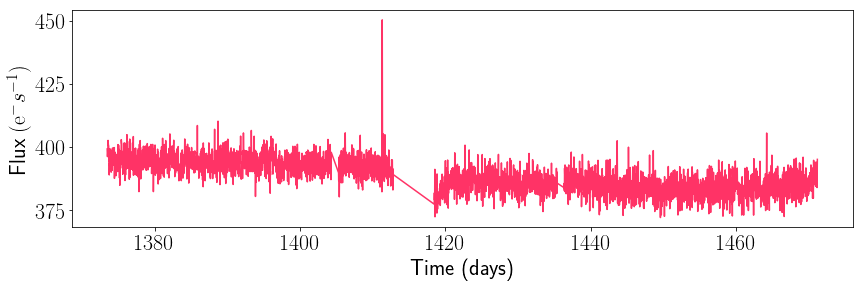

In [137]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, flux, color='#ff3366')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

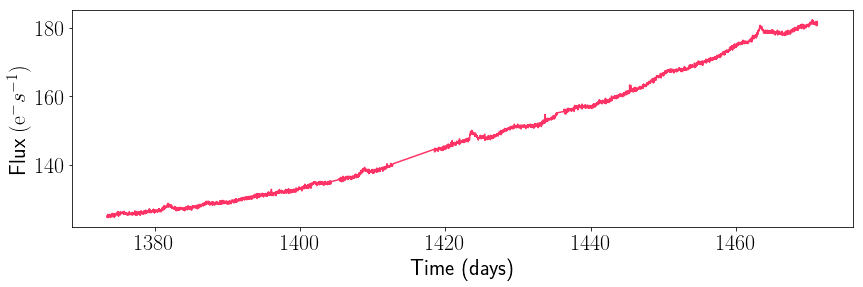

In [111]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, bkg, color='#ff3366')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

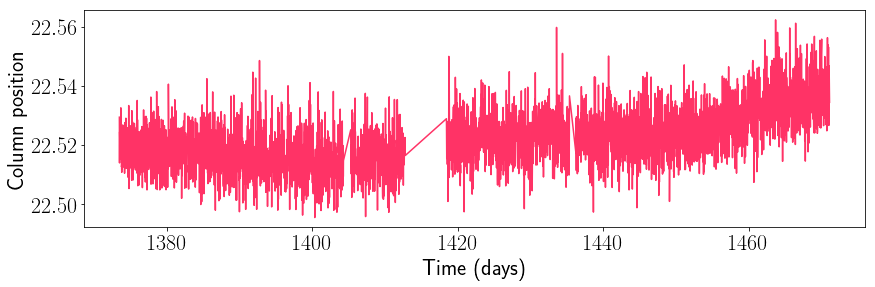

In [106]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter, color='#ff3366')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

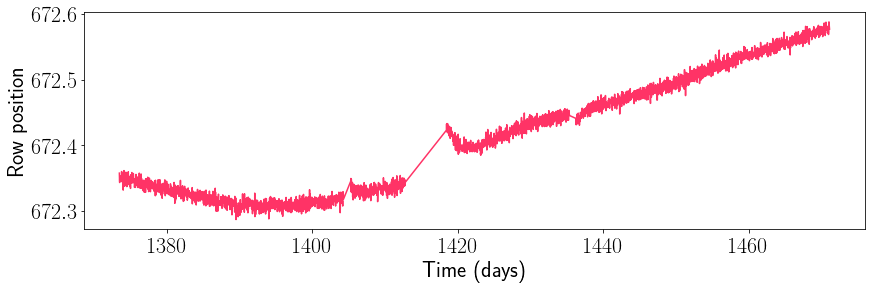

In [107]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter, color='#ff3366')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

In [108]:
residuals_poisson = phot_poisson.residuals

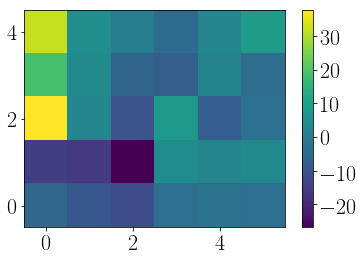

In [109]:
plt.imshow(residuals_poisson[-1], origin='lower')
plt.colorbar()

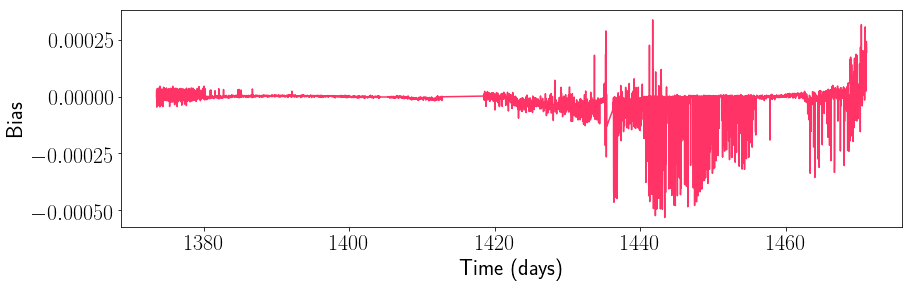

In [110]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, np.nanmean(residuals_poisson, axis=(1,2)), color='#ff3366')
plt.ylabel('Bias')
plt.xlabel('Time (days)')

In [112]:
from oktopus import GaussianPosterior
import tqdm

In [113]:
opt_params = np.array([])
residuals = np.array([])
uncertainties = np.array([])
for i in tqdm.tqdm(range(0, tpf.flux.shape[0])):
    loss = GaussianPosterior(data=tpf.flux[i] + tpf.flux_bkg[i], mean=scene,
                             var=tpf.flux[i] + tpf.flux_bkg[i], prior=prior)
    result = loss.fit(x0=prior.mean, method='powell')
    opt_params = np.append(opt_params, result.x)
    residuals = np.append(residuals, tpf.flux[i] + tpf.flux_bkg[i] - scene(*result.x))
    uncertainties = np.append(uncertainties, loss.loglikelihood.uncertainties(result.x))
opt_params = opt_params.reshape((tpf.flux.shape[0], 4))
residuals = residuals.reshape(tpf.flux.shape)

  0%|          | 0/4118 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 4118/4118 [03:31<00:00, 21.09it/s]


In [114]:
flux_gauss = opt_params[:, 0]
xcenter_gauss = opt_params[:, 1]
ycenter_gauss = opt_params[:, 2]
bkg_gauss = opt_params[:, 3]

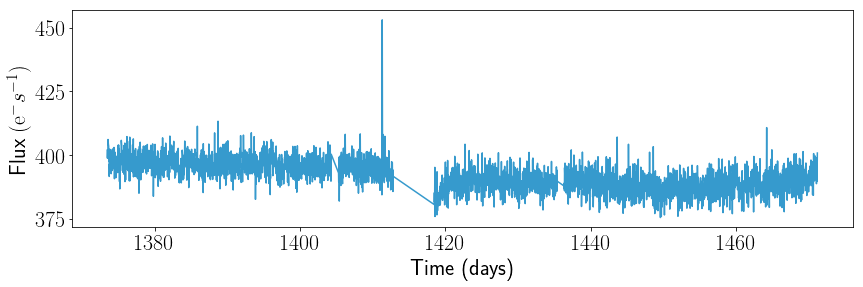

In [120]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, flux_gauss, color='#369acd')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

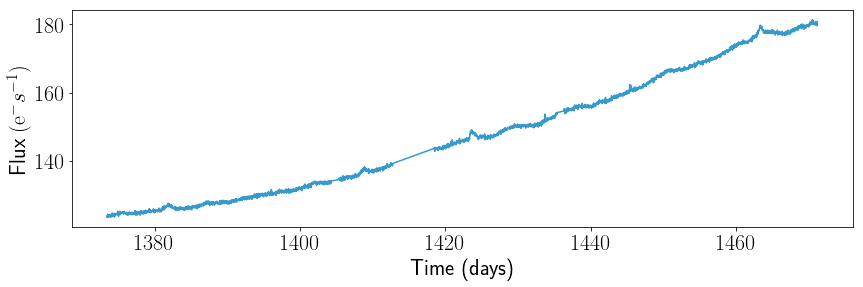

In [121]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, bkg_gauss, color='#369acd')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

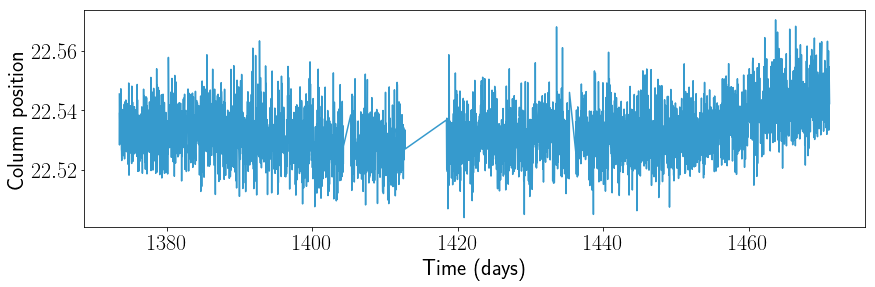

In [116]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter_gauss, color='#369acd')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

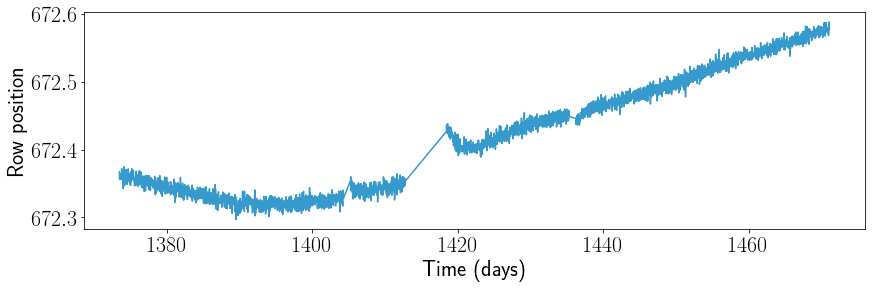

In [117]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter_gauss, color='#369acd')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

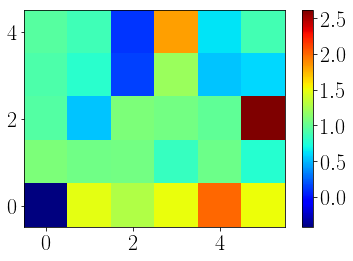

In [124]:
i=157
plt.imshow(residuals_poisson[i]/residuals[i], origin='lower', cmap='jet')
plt.colorbar()

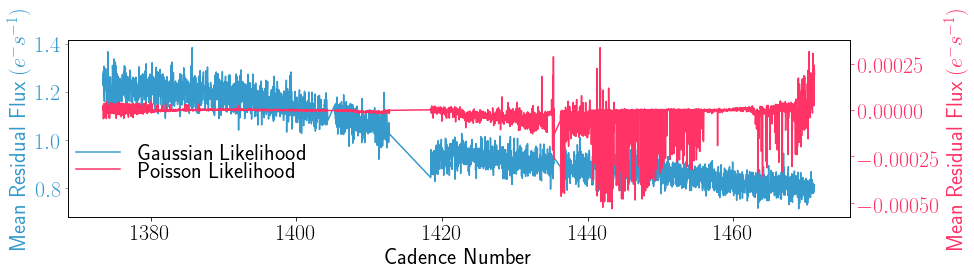

In [132]:
fig, ax1 = plt.subplots(figsize=[14, 4])
ax1.plot(tpf.time, np.nanmean(residuals, axis=(1, 2)), color='#369acd', label='Gaussian Likelihood')
ax1.set_xlabel('Cadence Number')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#369acd')
ax1.tick_params('y', colors='#369acd')
plt.legend(loc=(0,.25), frameon=False)

ax2 = ax1.twinx()
ax2.plot(tpf.time, np.nanmean(residuals_poisson, axis=(1, 2)), color='#ff3366', label='Poisson Likelihood')
ax2.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#ff3366')
ax2.tick_params('y', colors='#ff3366')
plt.legend(loc=(0,.15), frameon=False)
plt.tight_layout()

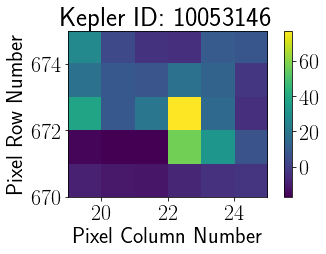

In [130]:
tpf.plot(cadenceno=66662)
plt.tight_layout()